## Import all required packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import math

## Scape the Houston zip codes from local site

In [2]:
page = requests.get("https://www.houstonproperties.com/houston-neighborhoods/houston-zip-code-map")
content=page.content

#df = pd.DataFrame(columns=['ZipCode'])

# Create a pandas dataframe from the HTML content
df1 = pd.read_html(content,header=0)[0] 
df1.loc[-1]=df1.columns
df1.index = df1.index+1 # the original dataframe had a header row with zip codes. This copies the header row and pastes it at the bottom of the dataframe
df1 = df1.sort_index()
df1 = df1.stack().dropna() # stack() makes the data frame 1 column and then all na rows are dropped
df1=df1.astype('int32')
zcodes = df1.values

## Obtain the latitude and longitude of Houston for later use

In [3]:
address = 'Houston, Texas'
geolocator = Nominatim(user_agent="dnipro")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

## Obtain the latitude and longitude of all zip codes in Houston

#### The below code is only required to run one time because I exported the data to an excel file and I can import it from there



lat=[]
long=[]
zips = []
for i in range(0,len(zcodes)):
    try:
        geolocator = Nominatim(user_agent="foursquare")
        location = geolocator.geocode(query = str(zcodes[i]),country_codes='US',timeout=2)
        lat.append(location.latitude)
        long.append(location.longitude)
        zips.append(zcodes[i])
    except:
        print("Zipcode",zcodes[i],"not in US?")

htown = pd.DataFrame(np.array([zips,lat,long]).T,columns=['ZipCode','Latitude','Longitude'])
htown.to_csv("Capstone.csv",index=False) # send the htown dataframe to an excel file so that I do not have to run this code multiple times

#### It was found that all of the "except" zip codes printed above are PO Box type zipcodes and should not be included for the purposes of this analysis

In [4]:
htown=pd.read_csv("Capstone.csv") #this is the excel file that was saved from the above code
htown.ZipCode = htown.ZipCode.astype('int32') # ensure the datatype is integer

## Plot all the Houston zip codes on a folium map to ensure the map populates correctly

#### the for loop reads all the latitudes and longitudes of the zip codes from the htown dataframe. 

In [5]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


for lat, lon, zips in zip(htown['Latitude'], htown['Longitude'], htown['ZipCode']):
    label = folium.Popup(str(zips),parse_html=True) # create a pop up window on the marker that shows the zip code
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Scrape the median home value from Zillow.  

#### This is a little complicated due to CAPTCHA. In order to get around CAPTCHA, a HTTP header is used (req_headers).

In [6]:
def scrape(zipcode):

    req_headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.8',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Chrome/61.0.3163.100'
    }
    with requests.Session() as s:
        url = "https://www.zillow.com/houston-tx-"+zipcode+"/home-values/ "   
        r = s.get(url, headers=req_headers)
        soup1 = BeautifulSoup(r.content)
        value = soup1.find("div",class_="zsg-lg-1-3 zsg-md-1-1 zsg-sm-1-1 region-info-left").find('h2').string
        return value

zipcodes=np.array(htown.ZipCode)
values = []
ers = []
for i in range(0,len(zipcodes)):
    try:
        values.append(scrape(str(zipcodes[i]))) # call the scrape function from above
    except:
        ers.append(zipcodes[i]) # this is to check for errors (i.e. if a zip code doesn't exist on the zillow website)

#### The median home value is scraped from zillow as a string (i.e. $200,000). The dollar sign must be stripped away and the "," must be removed.

htown['MedianHomeValue']=values
htown.MedianHomeValue=htown.MedianHomeValue.str.strip('$')
htown.MedianHomeValue=htown.MedianHomeValue.str.replace(",","").astype(float) # remove the comma and make the values floating type data
htown.to_csv("Htown_Neighborhoods.csv",index=False)

#### The above code is only ran once and then exported to a csv file so that anytime the median home value is required, it can simply be loaded from csv rather than scraping it from zillow

In [7]:
htown = pd.read_csv("Htown_Neighborhoods.csv") # load the htown dataframe

In [8]:
htown.head()

,ZipCode,Latitude,Longitude,MedianHomeValue
0,77002,29.757910,-95.375337,210745.0
1,77021,29.682851,-95.351038,165192.0
2,77040,29.870872,-95.540896,199961.0
3,77059,29.599062,-95.118861,347058.0
4,77078,29.836005,-95.235322,137272.0


## Obtain venue categories from the Foursquare API

#### After obtaining the venue data, I exported the venue information to an excel file for later use so that I did not use all of my calls to Foursquare

In [9]:
fsq = pd.read_excel('foursquare.xlsx') #My foursquare credentials are keep in an excel file
CLIENT_ID = fsq['CLIENT_ID'][0] # Foursquare ID
CLIENT_SECRET = fsq['CLIENT_SECRET'][0] # Foursquare Secret
VERSION = '20201205' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500): # radius can be varied
    
    venues_list=[]
    ers=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            ers.append(names)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'ZipCode Latitude', 
                  'ZipCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues,ers)

In [11]:
venues,ers = getNearbyVenues(names=htown['ZipCode'],
                         latitudes=htown['Latitude'],
                         longitudes=htown['Longitude'])

In [12]:
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 392 unique categories.


## Make a one-hot encoded dataframe for venue category

In [13]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add ZipCode column back to dataframe
onehot['ZipCode'] = venues['ZipCode'] 

# move ZipCode column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

grouped = onehot.groupby('ZipCode').mean().reset_index() # this groups the zip codes and assigns a weight to each venue category per zip code
grouped.head()

,ZipCode,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,American Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,77002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,...,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,77003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,...,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.0
2,77004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.0
3,77005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.01,0.00,0.0
4,77006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.01,0.1


grouped.to_csv("grouped_radius_2500.csv", index=False)

In [14]:
grouped = pd.read_csv("grouped_radius_2500.csv") # read the grouped dataframe from the csv file that was earlier exported

In [15]:
grouped.head()

,ZipCode,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,Alternative Healer,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,77002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,77003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.00,0.00,0.0
2,77004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.0
3,77005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.01,0.00,0.0
4,77006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.01,0.1


## Obtain the most common venues per zip code

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10 # number of top venues to display

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZipCode'] = grouped['ZipCode']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,77002,Hotel,Coffee Shop,Vietnamese Restaurant,American Restaurant,Brewery,Park,Mexican Restaurant,Bar,Wine Bar,Beer Bar
1,77003,Vietnamese Restaurant,Hotel,Park,Coffee Shop,American Restaurant,Brewery,Mexican Restaurant,Bar,Wine Bar,Breakfast Spot
2,77004,Bar,Vietnamese Restaurant,Coffee Shop,American Restaurant,Breakfast Spot,Nightclub,Southern / Soul Food Restaurant,Mexican Restaurant,Brewery,BBQ Joint
3,77005,Mexican Restaurant,Café,Burger Joint,Seafood Restaurant,New American Restaurant,Coffee Shop,Gym,Sushi Restaurant,Wine Bar,Bakery
4,77006,Zoo Exhibit,Coffee Shop,Mexican Restaurant,Bar,Science Museum,American Restaurant,Trail,Art Gallery,Park,Japanese Restaurant


## Obtain the Crime Data of Houston for 2019

In [18]:
crimedf = pd.read_csv("HoustonCrime_2019.csv") # csv that was downloaded from the Houston government website


crimedf.drop(columns=['Incident', 'Occurrence\nDate', 'Occurrence\nHour','NIBRS\nClass','Offense\nCount', 'Beat', 'Premise', 'Block Range',
       'StreetName', 'Street\nType', 'Suffix', 'City'],inplace=True) #drop all unnecessary columns

crimedf.rename(columns={'NIBRSDescription':'Description','ZIP Code':'ZipCode'},inplace=True) # rename the remaining columns
crimedf.fillna(0,inplace=True) # fill the n/a values with 0
crimedf.ZipCode = crimedf.ZipCode.astype('int64') # ensure datatype is integer
crimezip = crimedf.groupby(['ZipCode']).size() # This tells us the number of crimes per zip code
crimenorm = pd.DataFrame(crimezip/np.linalg.norm(crimezip),columns=['NormalizedCrimeCount']) # Normalize the crime rate
crimenorm.reset_index(inplace=True)

#### The below code checks for missing zip codes in the crime data and then assigns that zip code the mean crime rate so that we are not missing any zip codes

In [19]:
miszips=neighborhoods_venues_sorted.ZipCode.isin(crimenorm.ZipCode) 
miszips=miszips.loc[miszips==False].index
addzip = []

for i in range(0,len(miszips)):
    addzip.append(neighborhoods_venues_sorted.ZipCode.iloc[miszips[i]])
addzips = pd.DataFrame(np.array([addzip,np.ones(len(miszips))*crimenorm.NormalizedCrimeCount.mean()]).T,columns=['ZipCode','NormalizedCrimeCount'])
crimenorm=pd.concat([crimenorm,addzips])



grouped=grouped.merge(crimenorm,left_on='ZipCode',right_on='ZipCode')

## Cluster the zip codes

#### The kmeans clustering method will be used. The first thing to consider is the optimal number of clusters. Below the elbow method is used to determine the optimal number of clusters

Text(0, 0.5, 'Inertia')

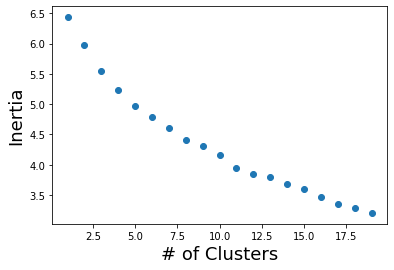

In [20]:
grouped_clustering = grouped.drop('ZipCode', 1)

iarray = [] #inertia array
nclusters = [] # number of clusers array
K = range(1,20)
for i in K:
    km = KMeans(n_clusters=i,n_init=50, max_iter=1000, n_jobs=-1, random_state=0).fit(grouped_clustering)
    iarray.append(km.inertia_)
    nclusters.append(i)
    
iarray = np.array(iarray)
nclusters=np.array(nclusters)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(nclusters,iarray)
ax.set_xlabel('# of Clusters',fontsize=18)
ax.set_ylabel('Inertia',fontsize=18)



## The below code calculates the optimal k automatically

#### refer to https://www.youtube.com/watch?v=IEBsrUQ4eMc for further information on how this works

In [21]:
def calc_distance(x1,y1,a,b,c):
    d=abs((a*x1+b*y1+c))/(math.sqrt(a*a+b*b))
    return d

a = iarray[0]-iarray[-1]
b = K[-1]-K[0]
c1 = K[0] * iarray[-1]
c2 = K[-1] * iarray[0]
c = c1-c2

In [22]:
dis_from_line = []
for k in range(19):
    dis_from_line.append(calc_distance(K[k], iarray[k],a,b,c))
opt_k = dis_from_line.index(max(dis_from_line))+1

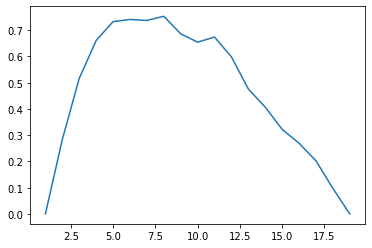

In [23]:
plt.plot(K,dis_from_line) # plot to distance vs K to visualize where the max distance is occuring

In [24]:
# run k-means clustering with the optimal k value
kclusters = opt_k
kmeans = KMeans(n_clusters=kclusters, n_init=50, max_iter=1000, random_state=0, n_jobs=-1).fit(grouped_clustering)
print("The optimal K value is",opt_k)

The optimal K value is 8


## Prepare a dataframe containing the top ten venues per zip code. This will be used for the final analysis

In [25]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) # insert a new column
merged = htown.merge(crimenorm,left_on='ZipCode',right_on='ZipCode')

# merge grouped with neighborhoods data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('ZipCode'), on='ZipCode').dropna()

In [26]:
merged['Cluster Labels']=merged['Cluster Labels'].astype('int64')
print("The unique cluster labels are ",merged['Cluster Labels'].unique())

The unique cluster labels are  [0 2 1 4 7 6 5 3]


In [27]:
print("The normalized average crime rate for each cluster is", [merged[merged['Cluster Labels']==i].sort_values(by='MedianHomeValue').NormalizedCrimeCount.mean() for i in merged['Cluster Labels'].unique()])

The normalized average crime rate for each cluster is [0.13349499938382647, 0.11866450326847651, 0.01599143140952572, 0.025016064774793463, 0.022181443827876086, 0.028587473007995745, 0.004486812537000262, 0.04746278842989062]


## Plot the Houston zip codes with a color defining the cluster that it belongs to. 

In [28]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['ZipCode'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

## The below code is used for exploratory analysis to view zip codes and venues in certain clusters

In [29]:
merged[(merged['Cluster Labels']==4) & (merged.MedianHomeValue>=200000)].sort_values(by='MedianHomeValue')

,ZipCode,Latitude,Longitude,MedianHomeValue,NormalizedCrimeCount,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
108,77449,29.820914,-95.736380,200595.0,0.000566,4,Pizza Place,Convenience Store,Donut Shop,Video Store,Discount Store,Mobile Phone Shop,Gym / Fitness Center,Mexican Restaurant,Ice Cream Shop,Cosmetics Shop
93,77504,29.637405,-95.180398,205810.0,0.003846,4,Fast Food Restaurant,Gas Station,Fried Chicken Joint,Hotel,Mexican Restaurant,Discount Store,Breakfast Spot,Video Store,Furniture / Home Store,Sandwich Place
99,77089,29.600444,-95.247820,208146.0,0.064965,4,Pizza Place,Fast Food Restaurant,Grocery Store,Gas Station,Convenience Store,Pharmacy,Coffee Shop,Chinese Restaurant,Sandwich Place,Mobile Phone Shop
148,77536,29.712045,-95.148323,212100.0,0.000264,4,Convenience Store,Baseball Field,Gas Station,Motel,Soccer Field,Park,Travel & Transport,Clothing Store,Golf Course,Fast Food Restaurant
36,77044,29.823634,-95.226747,222113.0,0.008634,4,Business Service,Gas Station,Ice Cream Shop,Golf Course,Sandwich Place,Fried Chicken Joint,Home Service,Donut Shop,Fast Food Restaurant,Intersection
67,77498,29.650600,-95.632229,237449.0,0.047463,4,Fast Food Restaurant,Gas Station,Pizza Place,Pharmacy,Sandwich Place,Chinese Restaurant,Indian Restaurant,Burger Joint,Grocery Store,Bank
16,77484,30.057681,-95.924940,250883.0,0.000038,4,Fast Food Restaurant,BBQ Joint,Gas Station,Mexican Restaurant,Pizza Place,Construction & Landscaping,Discount Store,Fried Chicken Joint,Donut Shop,Stadium
84,77429,29.991500,-95.645805,272114.0,0.000113,4,Pizza Place,Fast Food Restaurant,Donut Shop,Gas Station,Coffee Shop,Convenience Store,Sandwich Place,Gym / Fitness Center,Grocery Store,Spa
75,77407,29.666270,-95.696185,275316.0,0.047463,4,Pizza Place,Gym / Fitness Center,Gas Station,Pharmacy,Fast Food Restaurant,Burger Joint,Bubble Tea Shop,Taco Place,Big Box Store,Fried Chicken Joint
66,77406,29.650574,-95.756752,299309.0,0.047463,4,Fast Food Restaurant,Pizza Place,Coffee Shop,Donut Shop,Athletics & Sports,Supermarket,Thrift / Vintage Store,Automotive Shop,Movie Theater,Furniture / Home Store


In [30]:
merged[merged['Cluster Labels']==4].sort_values(by='MedianHomeValue')

,ZipCode,Latitude,Longitude,MedianHomeValue,NormalizedCrimeCount,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,77078,29.836005,-95.235322,137272.0,0.060968,4,Discount Store,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Donut Shop,Tree,American Restaurant,Gas Station,Golf Course,Grocery Store
150,77039,29.894270,-95.361422,149976.0,0.001169,4,Discount Store,Taco Place,Construction & Landscaping,Convenience Store,American Restaurant,Sandwich Place,Donut Shop,Field,Pharmacy,Burger Joint
135,77037,29.871436,-95.386808,153834.0,0.049619,4,Convenience Store,Discount Store,Food Truck,Fried Chicken Joint,Seafood Restaurant,Gas Station,Taco Place,Furniture / Home Store,Sandwich Place,Pizza Place
110,77015,29.789751,-95.163337,160829.0,0.052673,4,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Discount Store,Sandwich Place,Seafood Restaurant,Pharmacy,Gas Station,Burger Joint,Wings Joint
72,77067,29.944207,-95.451140,166015.0,0.056368,4,Vietnamese Restaurant,Discount Store,Grocery Store,Pizza Place,Sandwich Place,Chinese Restaurant,Thai Restaurant,BBQ Joint,Bakery,Theme Park
73,77086,29.932454,-95.509985,167957.0,0.001357,4,Gas Station,Fast Food Restaurant,Sandwich Place,Food Truck,Ice Cream Shop,Discount Store,Mexican Restaurant,Fried Chicken Joint,Vegetarian / Vegan Restaurant,Business Service
142,77038,29.908726,-95.431240,170409.0,0.015006,4,Fast Food Restaurant,Mexican Restaurant,Gas Station,Fried Chicken Joint,Convenience Store,Discount Store,Seafood Restaurant,Pizza Place,Electronics Store,Sandwich Place
25,77489,29.591184,-95.534471,173616.0,0.031332,4,Discount Store,Fried Chicken Joint,Pizza Place,Pharmacy,Park,Convenience Store,Fast Food Restaurant,Donut Shop,Grocery Store,Gym
64,77085,29.613362,-95.492870,174508.0,0.043888,4,Fast Food Restaurant,Discount Store,Sandwich Place,Intersection,Hotel,Athletics & Sports,Grocery Store,Clothing Store,Bakery,Tex-Mex Restaurant
121,77073,30.012184,-95.376864,179899.0,0.001169,4,Fast Food Restaurant,Pizza Place,Gas Station,Fried Chicken Joint,Discount Store,Video Store,Food,Baseball Field,Liquor Store,Storage Facility
